# nuScenes-lidarseg tutorial

Welcome to the nuScenes-lidarseg tutorial.

This demo assumes that nuScenes is installed at `/data/sets/nuscenes`. The mini version (i.e. v1.0-mini) of the full dataset will be used for this demo.

## Setup
To install the nuScenes-lidarseg expansion, download the dataset from https://www.nuscenes.org/download. Unpack the compressed file(s) into `/data/sets/nuscenes` and your folder structure should end up looking like this:
```
└── nuscenes  
    ├── Usual nuscenes folders (i.e. samples, sweep)
    │
    ├── lidarseg
    │   └── v1.0-{mini, test, trainval} <- Contains the .bin files; a .bin file 
    │                                      contains the labels of the points in a 
    │                                      point cloud (note that v1.0-test does not 
    │                                      have any .bin files associated with it)          
    └── v1.0-{mini, test, trainval}
        ├── Usual files (e.g. attribute.json, calibrated_sensor.json etc.)
        ├── lidarseg.json  <- contains the mapping of each .bin file to the token  
        └── category.json  <- contains the categories of the labels (note that the 
                              category.json from nuScenes v1.0 is overwritten)
```

## Google Colab (optional) 

<br>
<a href="https://colab.research.google.com/github/nutonomy/nuscenes-devkit/blob/master/python-sdk/tutorials/nuscenes_lidarseg_tutorial.ipynb">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/ align="left">
</a>
<br>

If you are running this notebook in Google Colab, you can uncomment the cell below and run it; everything will be set up nicely for you. Otherwise, go to [**Setup**](#Setup) to manually set up everything.

In [ ]:
# !mkdir -p /data/sets/nuscenes  # Make the directory to store the nuScenes dataset in.

# !wget https://www.nuscenes.org/data/v1.0-mini.tgz  # Download the nuScenes mini split.
# !wget https://www.nuscenes.org/data/nuScenes-lidarseg-mini-v1.0.tar.bz2  # Download the nuScenes-lidarseg mini split.

# !tar -xf v1.0-mini.tgz -C /data/sets/nuscenes  # Uncompress the nuScenes mini split.
# !tar -xf nuScenes-lidarseg-mini-v1.0.tar.bz2 -C /data/sets/nuscenes   # Uncompress the nuScenes-lidarseg mini split.

# !pip install nuscenes-devkit &> /dev/null  # Install nuScenes.

## Initialization
Let's start by importing the necessary libraries:

In [1]:
%matplotlib inline

from nuscenes import NuScenes

nusc = NuScenes(version='v1.0-mini', dataroot='/data/sets/nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-mini...
Loading nuScenes-lidarseg...
32 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
404 lidarseg,
Done loading in 0.354 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


As you can see, you do not need any extra libraries to use nuScenes-lidarseg. The original nuScenes devkit which you are familiar with has been extended so that you can use it seamlessly with nuScenes-lidarseg.

## Statistics of lidarseg dataset for the v1.0-mini split
Let's get a quick feel of the lidarseg dataset by looking at what classes are in it and the number of points belonging to each class. The classes will be sorted in ascending order based on the number of points (since `sort_by='count'` below); you can also sort the classes by class name or class index by setting `sort_by='name'` or `sort_by='index'` respectively.

In [2]:
nusc.list_lidarseg_categories(sort_by='count')

Calculating stats for nuScenes-lidarseg...
  1  animal                                   nbr_points=           0
  7  human.pedestrian.stroller                nbr_points=           0
  8  human.pedestrian.wheelchair              nbr_points=           0
 19  vehicle.emergency.ambulance              nbr_points=           0
 20  vehicle.emergency.police                 nbr_points=           0
 10  movable_object.debris                    nbr_points=          48
  6  human.pedestrian.police_officer          nbr_points=          64
  3  human.pedestrian.child                   nbr_points=         230
  4  human.pedestrian.construction_worker     nbr_points=       1,412
 14  vehicle.bicycle                          nbr_points=       1,463
 11  movable_object.pushable_pullable         nbr_points=       2,293
  5  human.pedestrian.personal_mobility       nbr_points=       4,096
 13  static_object.bicycle_rack               nbr_points=       4,476
 12  movable_object.trafficcone               n

With `list_lidarseg_categories`, you can get the index which each class name belongs to by looking at the leftmost column. You can also get a mapping of the indices to the class names from the `lidarseg_idx2name_mapping` attribute of the NuScenes class.

In [3]:
nusc.lidarseg_idx2name_mapping

{0: 'noise',
 1: 'animal',
 2: 'human.pedestrian.adult',
 3: 'human.pedestrian.child',
 4: 'human.pedestrian.construction_worker',
 5: 'human.pedestrian.personal_mobility',
 6: 'human.pedestrian.police_officer',
 7: 'human.pedestrian.stroller',
 8: 'human.pedestrian.wheelchair',
 9: 'movable_object.barrier',
 10: 'movable_object.debris',
 11: 'movable_object.pushable_pullable',
 12: 'movable_object.trafficcone',
 13: 'static_object.bicycle_rack',
 14: 'vehicle.bicycle',
 15: 'vehicle.bus.bendy',
 16: 'vehicle.bus.rigid',
 17: 'vehicle.car',
 18: 'vehicle.construction',
 19: 'vehicle.emergency.ambulance',
 20: 'vehicle.emergency.police',
 21: 'vehicle.motorcycle',
 22: 'vehicle.trailer',
 23: 'vehicle.truck',
 24: 'flat.driveable_surface',
 25: 'flat.other',
 26: 'flat.sidewalk',
 27: 'flat.terrain',
 28: 'static.manmade',
 29: 'static.other',
 30: 'static.vegetation',
 31: 'vehicle.ego'}

Conversely, you can get the mapping of the class names to the indices from the `lidarseg_name2idx_mapping` attribute of the NuScenes class.

In [4]:
nusc.lidarseg_name2idx_mapping

{'noise': 0,
 'animal': 1,
 'human.pedestrian.adult': 2,
 'human.pedestrian.child': 3,
 'human.pedestrian.construction_worker': 4,
 'human.pedestrian.personal_mobility': 5,
 'human.pedestrian.police_officer': 6,
 'human.pedestrian.stroller': 7,
 'human.pedestrian.wheelchair': 8,
 'movable_object.barrier': 9,
 'movable_object.debris': 10,
 'movable_object.pushable_pullable': 11,
 'movable_object.trafficcone': 12,
 'static_object.bicycle_rack': 13,
 'vehicle.bicycle': 14,
 'vehicle.bus.bendy': 15,
 'vehicle.bus.rigid': 16,
 'vehicle.car': 17,
 'vehicle.construction': 18,
 'vehicle.emergency.ambulance': 19,
 'vehicle.emergency.police': 20,
 'vehicle.motorcycle': 21,
 'vehicle.trailer': 22,
 'vehicle.truck': 23,
 'flat.driveable_surface': 24,
 'flat.other': 25,
 'flat.sidewalk': 26,
 'flat.terrain': 27,
 'static.manmade': 28,
 'static.other': 29,
 'static.vegetation': 30,
 'vehicle.ego': 31}

## Pick a sample token
Let's pick a sample to use for this tutorial.

In [5]:
my_sample = nusc.sample[87]

## Get statistics of a lidarseg sample token
Now let's take a look at what classes are present in the pointcloud of this particular sample.

In [6]:
nusc.get_sample_lidarseg_stats(my_sample['token'], sort_by='count')

===== Statistics for 6dabc0fb1df045558f802246dd186b3f =====
 14  vehicle.bicycle                          n=           9
 11  movable_object.pushable_pullable         n=          11
  0  noise                                    n=          62
  2  human.pedestrian.adult                   n=          71
 16  vehicle.bus.rigid                        n=         105
  9  movable_object.barrier                   n=         280
 22  vehicle.trailer                          n=         302
 30  static.vegetation                        n=         330
 23  vehicle.truck                            n=       1,229
 26  flat.sidewalk                            n=       1,310
 25  flat.other                               n=       1,495
 17  vehicle.car                              n=       3,291
 28  static.manmade                           n=       4,650
 24  flat.driveable_surface                   n=       9,884
 31  vehicle.ego                              n=      11,723


By doing `sort_by='count'`, the classes and their respective frequency counts are printed in ascending order; you can also do `sort_by='name'` and `sort_by='index'` here as well.

## Render the lidarseg labels in the bird's eye view of a pointcloud
In the original nuScenes devkit, you would pass a sample data token into ```render_sample_data``` to render a bird's eye view of the pointcloud. However, the points would be colored according to the distance from the ego vehicle. Now with the extended nuScenes devkit, all you need to do is set ```show_lidarseg=True``` to visualize the class labels of the pointcloud.

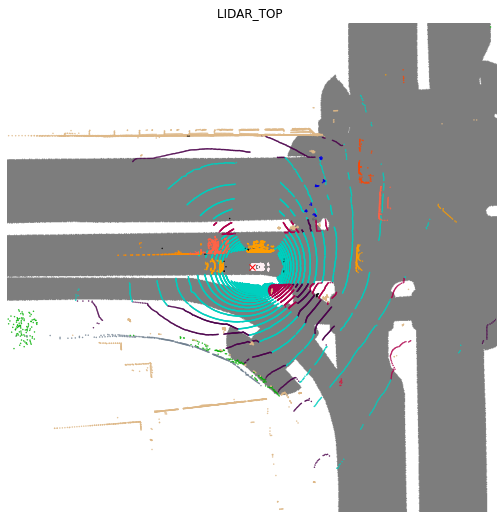

In [7]:
sample_data_token = my_sample['data']['LIDAR_TOP']
nusc.render_sample_data(sample_data_token,
                        with_anns=False,
                        show_lidarseg=True)

But what if you wanted to focus on only certain classes? Given the statistics of the pointcloud printed out previously, let's say you are only interested in trucks and trailers. You could see the class indices belonging to those classes from the statistics and then pass an array of those indices into ```filter_lidarseg_labels``` like so:

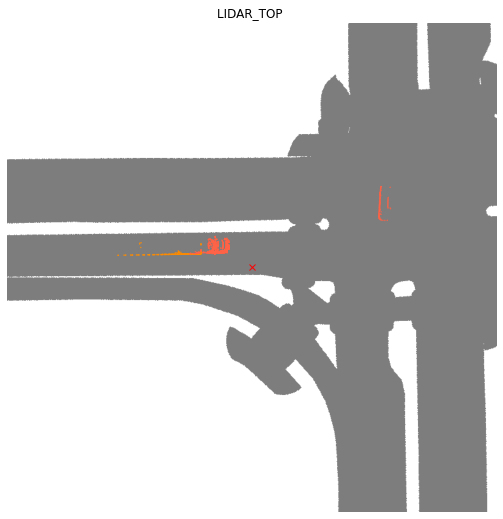

In [8]:
nusc.render_sample_data(sample_data_token,
                        with_anns=False,
                        show_lidarseg=True,
                        filter_lidarseg_labels=[22, 23])

Now only points in the pointcloud belonging to trucks and trailers are filtered out for your viewing pleasure. 

In addition, you can display a legend which indicates the color for each class by using `show_lidarseg_legend`.

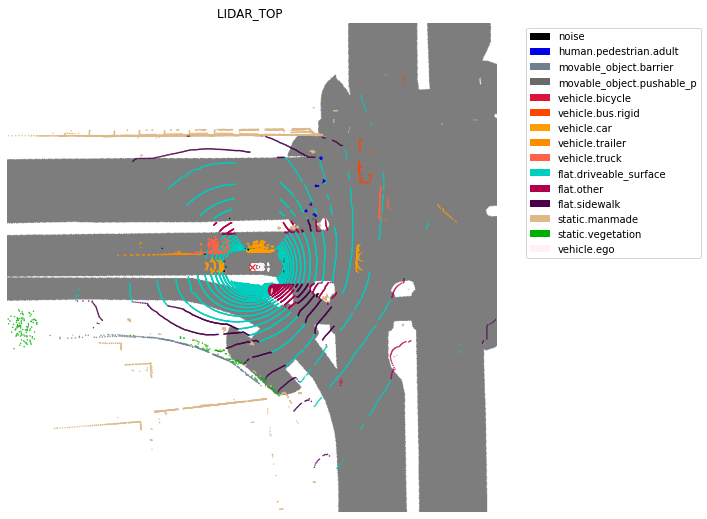

In [9]:
nusc.render_sample_data(sample_data_token,
                        with_anns=False,
                        show_lidarseg=True,
                        show_lidarseg_legend=True)

## Render lidarseg labels in image
If you wanted to superimpose the pointcloud into the corresponding image from a camera, you can use ```render_pointcloud_in_image``` like what you would do with the original nuScenes devkit, but set ```show_lidarseg=True``` (remember to set ```render_intensity=False```). Similar to ```render_sample_data```, you can filter to see only certain classes using ```filter_lidarseg_labels```. And you can use ```show_lidarseg_legend``` to display a legend in the rendering.

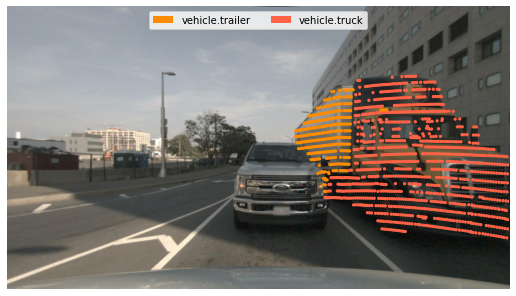

In [10]:
nusc.render_pointcloud_in_image(my_sample['token'],
                                pointsensor_channel='LIDAR_TOP',
                                camera_channel='CAM_BACK',
                                render_intensity=False,
                                show_lidarseg=True,
                                filter_lidarseg_labels=[22, 23],
                                show_lidarseg_legend=True)

## Render sample (i.e. lidar, radar and all cameras)
Of course, like in the original nuScenes devkit, you can render all the sensors at once with ```render_sample```. In this extended nuScenes devkit, you can set ```show_lidarseg=True``` to see the lidarseg labels. Similar to the above methods, you can use ```filter_lidarseg_labels``` to display only the classes you wish to see.

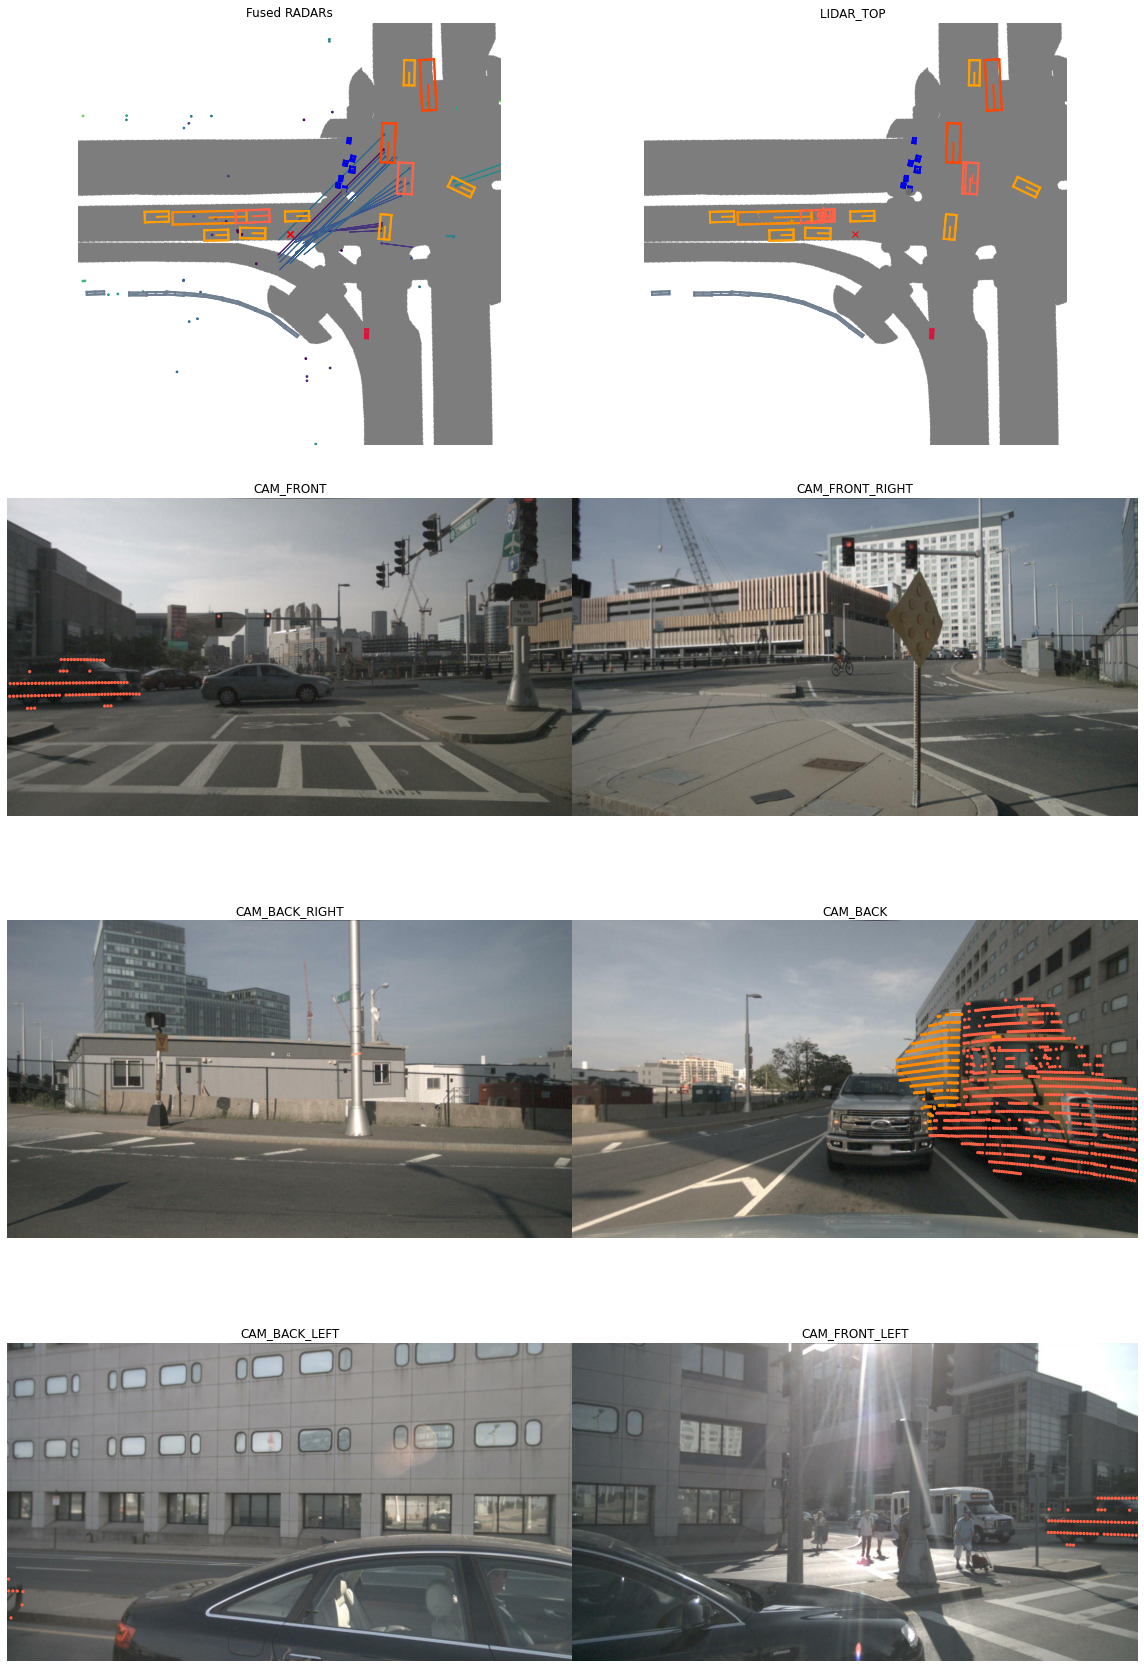

In [11]:
nusc.render_sample(my_sample['token'],
                   show_lidarseg=True,
                   filter_lidarseg_labels=[22, 23])

## Render a scene for a given camera sensor with lidarseg labels
You can also render an entire scene with the lidarseg labels for a camera of your choosing (the ```filter_lidarseg_labels``` argument can be used here as well).

Let's pick a scene first:

In [12]:
my_scene = nusc.scene[0]

We then pass the scene token into ```render_scene_channel_lidarseg``` indicating that we are only interested in construction vehicles and man-made objects (here, we set `verbose=True` to produce a window which will allows us to see the frames as they are being random). 

In addition, you can use `dpi` (to adjust the size of the lidar points) and `imsize` (to adjust the size of the rendered image) to tune the aesthetics of the renderings to your liking.

(Note: the following code is commented out as it crashes in Jupyter notebooks.)

In [ ]:
# import os
# nusc.render_scene_channel_lidarseg(my_scene['token'], 
#                                    'CAM_BACK', 
#                                    filter_lidarseg_labels=[18, 28],
#                                    verbose=True, 
#                                    dpi=100,
#                                    imsize=(1280, 720))

To save the renderings, you can pass a path to a folder you want to save the images to via the ```out_folder``` argument, and either `video` or `image` to `render_mode`.

(Note: the following code is commented out as it crashes in Jupyter notebooks.)

In [ ]:
# nusc.render_scene_channel_lidarseg(my_scene['token'],
#                                    'CAM_BACK',
#                                    filter_lidarseg_labels=[18, 28],
#                                    verbose=True,
#                                    dpi=100,
#                                    imsize=(1280, 720),
#                                    render_mode='video',
#                                    out_folder=os.path.expanduser('~/Desktop/my_folder'))

When `render_mode='image'`, only frames which contain points (after the filter has been applied) will be saved as images.

## Render a scene for all cameras with lidarseg labels
You can also render the entire scene for all cameras at once with the lidarseg labels as a video. Let's say in this case, we are interested in points belonging to driveable surfaces and cars.

(Note: the following code is commented out as it crashes in Jupyter notebooks.)

In [ ]:
# nusc.render_scene_lidarseg(my_scene['token'], 
#                            filter_lidarseg_labels=[17, 24],
#                            verbose=True,
#                            dpi=100,
#                            out_path=os.path.expanduser('~/Desktop/my_rendered_scene.avi'))

## Visualizing LIDAR segmentation predictions
In all the above functions, the labels of the LIDAR pointcloud which have been rendered are the ground truth. If you have trained a model to segment LIDAR pointclouds and have run it on the nuScenes-lidarseg dataset, you can visualize your model's predictions with nuScenes-lidarseg as well!

Each of your .bin files should be a `numpy.uint8` array; as a tip, you can save your predictions as follows:
```
np.array(predictions).astype(np.uint8).tofile(bin_file_out)
```
- `predictions`: The predictions from your model (e.g. `[30, 5, 18, ..., 30]`)
- `bin_file_out`: The path to write your .bin file to (e.g. `/some/folder/<lidar_sample_data_token>_lidarseg.bin`)

Then you simply need to pass the path to the .bin file where your predictions for the given sample are to `lidarseg_preds_bin_path` for these functions:
- `list_lidarseg_categories`
- `render_sample_data`
- `render_pointcloud_in_image`
- `render_sample`                 

For example, let's assume the predictions for `my_sample` is stored at `/data/sets/nuscenes/lidarseg/v1.0-mini` with the format `<lidar_sample_data_token>_lidarseg.bin`:

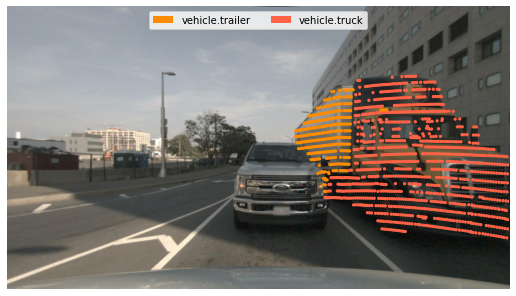

In [13]:
import os

my_sample = nusc.sample[87]
sample_data_token = my_sample['data']['LIDAR_TOP']
my_predictions_bin_file = os.path.join('/data/sets/nuscenes/lidarseg/v1.0-mini', sample_data_token + '_lidarseg.bin')

nusc.render_pointcloud_in_image(my_sample['token'],
                                pointsensor_channel='LIDAR_TOP',
                                camera_channel='CAM_BACK',
                                render_intensity=False,
                                show_lidarseg=True,
                                filter_lidarseg_labels=[22, 23],
                                show_lidarseg_legend=True,
                                lidarseg_preds_bin_path=my_predictions_bin_file)

For these functions that render an entire scene, you will need to pass the path to the folder which contains the .bin files for each sample in a scene to `lidarseg_preds_folder`:
- `render_scene_channel_lidarseg`
- `render_scene_lidarseg`

Pay special attention that **each set of predictions in the folder _must_ be a `.bin` file and named as `<lidar_sample_data_token>_lidarseg.bin`**.

(Note: the following code is commented out as it crashes in Jupyter notebooks.)

In [ ]:
# my_scene = nusc.scene[0]
# my_folder_of_predictions = '/data/sets/nuscenes/lidarseg/v1.0-mini'

# nusc.render_scene_channel_lidarseg(my_scene['token'], 
#                                    'CAM_BACK', 
#                                    filter_lidarseg_labels=[17, 24],
#                                    verbose=True, 
#                                    imsize=(1280, 720),
#                                    lidarseg_preds_folder=my_folder_of_predictions)

## Conclusion
And this brings us to the end of the tutorial for nuScenes-lidarseg, enjoy!